In [15]:
import altair as alt
alt.renderers.enable('notebook')
import pandas as pd
import numpy as np
import os
from vega_datasets import data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
from vega_datasets import data

def boxplot(data, x, y, ytype='Q', xtype='N'):
    # make all the aggregation strings up front
    min_agg = "min(%s):%s"%(y,ytype)
    max_agg = "max(%s):%s"%(y,ytype)
    median_agg = 'median(%s):%s'%(y,ytype)
    q1_agg = "q1(%s):%s"%(y,ytype)
    q3_agg = "q3(%s):%s"%(y,ytype)
    x_val = "%s:%s"%(x,xtype)

    # create a single base chart
    # which the other layers will
    # be augmented from
    base = alt.Chart(title = 'BoxPlot Difference of Temperature (C)').encode(
        x=x_val
    ).properties(
        width=400
    )

    # now we only need to specify what is unique
    # to each layer!
    whisker_low = base.mark_rule().encode(
        y=alt.Y(min_agg, axis=alt.Axis(title=y)),
        y2=q1_agg
    )

    box = base.mark_bar().encode(
        y=q1_agg,
        y2=q3_agg
    )

    midline = base.mark_tick(
        color='white',
    ).encode(
        y=median_agg,
        y2=median_agg
    )

    whisker_high = base.mark_rule().encode(
        y=max_agg,
        y2=q3_agg
    )

    # combine with layer()
    return alt.layer(whisker_low, box, whisker_high, midline, data=data)

df = data.seattle_weather()
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


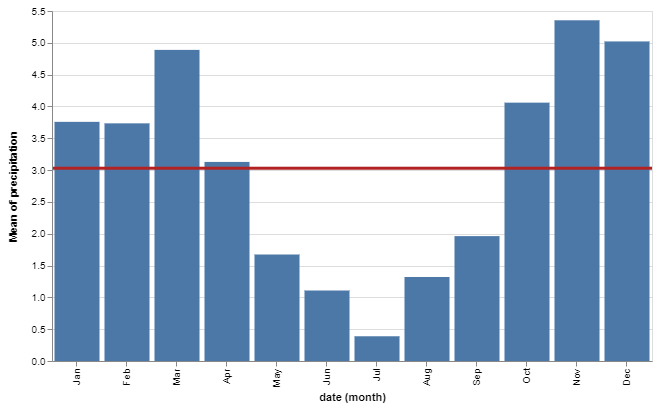

In [17]:
brush = alt.selection(type='interval', encodings=['x'])

bars = alt.Chart().mark_bar().encode(
    x='month(date):O',
    y='mean(precipitation):Q',
    opacity=alt.condition(brush, alt.OpacityValue(1), alt.OpacityValue(0.7)),
).properties(
    width=600,
    height=350).add_selection(
    brush
)

line = alt.Chart().mark_rule(color='firebrick').encode(
    y='mean(precipitation):Q',
    size=alt.SizeValue(3)
).transform_filter(
    brush
)

alt.layer(bars, line, data=df)

In [18]:
df['temp_diff'] = df.temp_max - df.temp_min
df.head(10)

,date,precipitation,temp_max,temp_min,wind,weather,temp_diff
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle,7.8
1,2012-01-02,10.9,10.6,2.8,4.5,rain,7.8
2,2012-01-03,0.8,11.7,7.2,2.3,rain,4.5
3,2012-01-04,20.3,12.2,5.6,4.7,rain,6.6
4,2012-01-05,1.3,8.9,2.8,6.1,rain,6.1
5,2012-01-06,2.5,4.4,2.2,2.2,rain,2.2
6,2012-01-07,0.0,7.2,2.8,2.3,rain,4.4
7,2012-01-08,0.0,10.0,2.8,2.0,sun,7.2
8,2012-01-09,4.3,9.4,5.0,3.4,rain,4.4
9,2012-01-10,1.0,6.1,0.6,3.4,rain,5.5


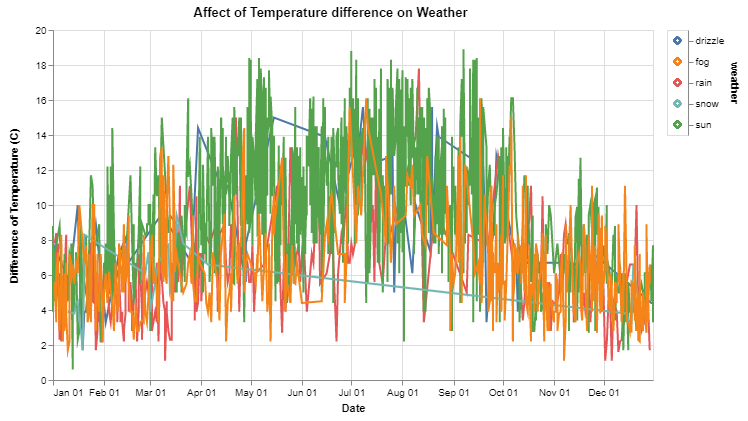

In [19]:
selection = alt.selection_multi(fields=['weather'])
color = alt.condition(selection,
                      alt.Color('weather:N', legend=None),
                      alt.value('lightgray'))

lines = alt.Chart(df,title='Affect of Temperature difference on Weather').mark_line().encode(
    alt.X('monthdate(date):T', title='Date'),
    alt.Y('temp_diff:Q',
        title='Difference of Temperature (C)'
    ),
    color=color,
    tooltip='Name:N'
).properties(
    width=600,
    height=350
)

legend = alt.Chart(df.reset_index()).mark_point().encode(
    y=alt.Y('weather:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)

lines | legend

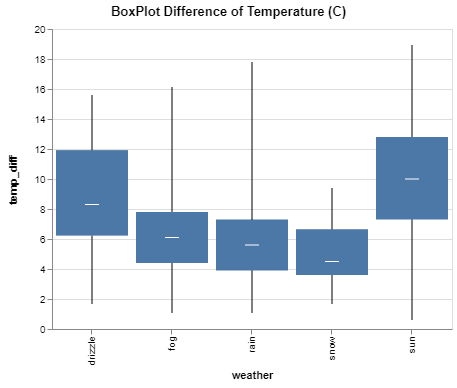

In [20]:
boxplot(df, x='weather', y='temp_diff')

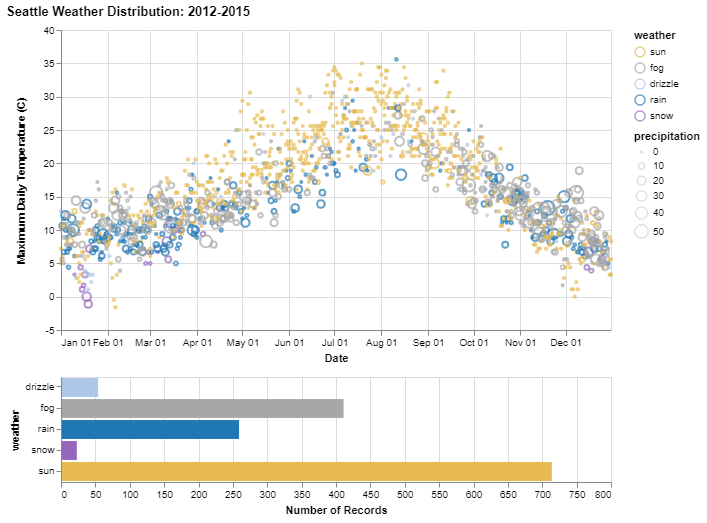

In [21]:
source = df

scale = alt.Scale(domain=['sun', 'fog', 'drizzle', 'rain', 'snow'],
                  range=['#e7ba52', '#a7a7a7', '#aec7e8', '#1f77b4', '#9467bd'])
color = alt.Color('weather:N', scale=scale)

# We create two selections:
# - a brush that is active on the top panel
# - a multi-click that is active on the bottom panel
brush = alt.selection_interval(encodings=['x'])
click = alt.selection_multi(encodings=['color'])

# Top panel is scatter plot of temperature vs time
points = alt.Chart().mark_point().encode(
    alt.X('monthdate(date):T', title='Date'),
    alt.Y('temp_max:Q',
        title='Maximum Daily Temperature (C)',
        scale=alt.Scale(domain=[-5, 40])
    ),
    color=alt.condition(brush, color, alt.value('lightgray')),
    size=alt.Size('precipitation:Q', scale=alt.Scale(range=[5, 200]))
).properties(
    width=550,
    height=300
).add_selection(
    brush
).transform_filter(
    click
)

# Bottom panel is a bar chart of weather type
bars = alt.Chart().mark_bar().encode(
    x='count()',
    y='weather:N',
    color=alt.condition(click, color, alt.value('lightgray')),
).transform_filter(
    brush
).properties(
    width=550,
).add_selection(
    click
)

alt.vconcat(
    points,
    bars,
    data=source,
    title="Seattle Weather Distribution: 2012-2015"
)